In [146]:
# ! pip install ipympl
#! pip install scikit-learn
#! pip install seaborn

In [164]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 데이터 로딩 및 전처리

In [165]:
# 예시 경로, 실제 경로로 수정 필요

# 게임에 참가한 사람들의 고유 정보
participants = pd.read_csv("data/top1000/participants.csv")
# 시간 흐름에 따라 변화하는 실시간 스탯 (골드, 딜량 등) 
participants_frames = pd.read_csv("data/top1000/participant_frames.csv")
# 게임 단위의 결과 (승패 등)
matches = pd.read_csv("data/top1000/matches.csv")
# 킬 이벤트 정보 (누가 누구를 죽였는지)
champ_kill = pd.read_csv('data/top1000/events__CHAMPION_KILL.csv')

In [166]:
# 가장 마지막 프레임만 사용 (게임 종료 시점 상태)
# 게임 종료 시점 기준으로 정보 하나로 묶기
latest_frames = participants_frames.sort_values("frame_timestamp").drop_duplicates(
    subset=["game_id", "participant_id"], keep='last'
)

merged_df = pd.merge(participants, latest_frames, on=["game_id", "participant_id"], how="left")

## 2. KDA 및 주요 파생 지표 생성

### KDA 계산

컬럼 | 의미
---- | ----
kills | 해당 경기에서 몇 번 킬 했는가
deaths | 몇 번 죽었는가
assists | 어시스트 수
KDA | (킬 + 어시스트) / 데스 (생존 기반 전투 영향력)

In [167]:
# kills 수 계산 (킬한 사람 기준)
kills = champ_kill.groupby(["game_id", "killer_id"]).size().reset_index(name="kills")
kills.rename(columns={"killer_id": "participant_id"}, inplace=True)

In [168]:
# deaths 수 계산 (죽은 사람 기준)
deaths = champ_kill.groupby(["game_id", "victim_id"]).size().reset_index(name="deaths")
deaths.rename(columns={"victim_id": "participant_id"}, inplace=True)

In [169]:
# assists 수 계산
assist_df = pd.read_csv("data/top1000/event_assists.csv")

# 게임 ID + 어시스트 참가자 ID로 그룹화
assists = assist_df.groupby(["game_id", "participant_id"]).size().reset_index(name="assists")


In [170]:
# KDA 구하기

# 기본 participant list (merged_df)에서 가져오자
kda_base = merged_df[["game_id", "participant_id", "puuid"]].drop_duplicates()

# 병합
kda_df = (
    kda_base
    .merge(kills, on=["game_id", "participant_id"], how="left")
    .merge(deaths, on=["game_id", "participant_id"], how="left")
)

# 어시스트 컬럼 있으면 병합
if 'assists' in locals():
    kda_df = kda_df.merge(assists, on=["game_id", "participant_id"], how="left")

# 결측값 0으로 채우기
kda_df[["kills", "deaths", "assists"]] = kda_df[["kills", "deaths", "assists"]].fillna(0).astype(int)

# KDA 계산
# 분모가 0이 되면 오류가 나기 때문에, 완벽 생존은 1로 나눈 값을 최대치로 보정
kda_df["KDA"] = (kda_df["kills"] + kda_df["assists"]) / kda_df["deaths"].replace(0, 1)


In [171]:
# merged_df에 병합

merged_df = pd.merge(merged_df, kda_df[["game_id", "participant_id", "kills", "deaths", "assists", "KDA"]],
                     on=["game_id", "participant_id"], how="left")
merged_df.head()

,game_id,participant_id,puuid,frame_timestamp,current_gold,gold_per_second,jungle_minions_killed,level,minions_killed,time_enemy_spent_controlled,...,totalDamageDone,totalDamageDoneToChampions,totalDamageTaken,trueDamageDone,trueDamageDoneToChampions,trueDamageTaken,kills,deaths,assists,KDA
0,7586549521,1,T2coi9U5HI63yttsRxRgUeQ2xLzedwMv0LWMV_Xtp812gj...,1956361,3780,0,4,18,236,227461,...,221039,38637,35625,26709,13168,3156,13,3,19,10.666667
1,7586549521,2,VzxkuEt2Ay_6P_1wY1FajjdMW8ty20cPLb0jmwqAAjA9Ns...,1956361,1597,0,142,17,22,171344,...,251617,26859,44796,65212,2829,2577,12,10,14,2.600000
2,7586549521,3,-jMFYAy4ogcmItoiwYmQX7tG2fB59CvKQieQwZqYvcLw1x...,1956361,2454,0,8,17,232,259989,...,206296,37478,31216,7563,1790,3254,4,11,19,2.090909
3,7586549521,4,CDtqv-NZS5cmtQI0bsfbxBhq29QlqmwX_YwgG5oW3PkhMm...,1956361,1339,0,16,18,199,130050,...,217726,47278,33657,9483,2649,782,16,11,15,2.818182
4,7586549521,5,72aXoGzHe_SjiP1hNKnMXyx_UYND4_HE2j1Awp9E3l6pge...,1956361,1189,50,0,14,15,226379,...,17701,12926,36143,3208,2008,2392,2,15,23,1.666667


## 유사도 기반 파생 지표 생성 (예시: 시야 점수, 미니언 수, 골드 등)

### 성장 및 경제 지표        

| 지표 | 의미 | 해석 |  
| ---- | ---- | ---- |   
| CS/Min | 분당 미니언 수급량 | 파밍 능력 |     
| Gold/Min | 분당 골드 | 성장 속도 |        
| XP/Min | 분당 경험치 | 레벨 성장 속도 |       




In [ ]:
# 성장 및 경제 지표

# 분당 라인 몬스터
merged_df['lane_cs_per_min'] = merged_df['minions_killed'] / (merged_df["frame_timestamp"] / 60000)

# 분당 정글 몬스터
merged_df['jungle_cs_per_min'] = merged_df['jungle_minions_killed'] / (merged_df["frame_timestamp"] / 60000)

# # CS (미니언 + 정글)
# merged_df["cs"] = merged_df["minions_killed"] + merged_df["jungle_minions_killed"]

# # 분당 CS
# merged_df["cs_per_min"] = merged_df["cs"] / (merged_df["frame_timestamp"] / 60000)

# jungle 성향 분석
merged_df['jungle_ratio'] = merged_df['jungle_minions_killed'] / (merged_df['jungle_minions_killed'] + merged_df['minions_killed'])

# 분당 골드
merged_df["gold_per_min"] = merged_df["total_gold"] / (merged_df["frame_timestamp"] / 60000)

# 분당 경험치
merged_df["xp_per_min"] = merged_df["xp"] / (merged_df["frame_timestamp"] / 60000)

### 전투 능력 지표

지표 | 의미 | 해석
---- | ---- | ----
Damage/Min | 분당 딜량 | 전투 기여도
Damage Taken/Min | 분당 받은 피해 | 탱킹 능력 또는 위험 노출
KA/Min | 분당 킬 관여 수 | 싸움 참여율 (적극적인지 여부)
Damage Efficiency | 피해 교환 비율 | 딜 효율 (딜을 얼마나 잘 넣고 덜 맞았는지)

In [173]:
# 전투력 관련 지표
# 분당 피해량
merged_df["damage_per_min"] = merged_df["totalDamageDoneToChampions"] / (merged_df["frame_timestamp"] / 60000)

# 분당 받은 피해량
merged_df["damage_taken_per_min"] = merged_df["totalDamageTaken"] / (merged_df["frame_timestamp"] / 60000)

# 분당 킬 관여율 (K+A)/시간
merged_df["ka_per_min"] = (merged_df["kills"] + merged_df["assists"]) / (merged_df["frame_timestamp"] / 60000)

# 피해 교환 효율 (딜량 / 받은 피해량)
merged_df["damage_efficiency"] = merged_df["totalDamageDoneToChampions"] / merged_df["totalDamageTaken"].replace(0, 1)


### 생존력 지표

지표 | 의미 | 해석
---- | ---- | ----
survivability | 생존률 | 
healthregen_per_min | 분당 체력 재생 | 


In [174]:
# 생존력 지표
# 생존률 (1 - 데스 / 평균 생존시간) → 데스 적을수록 높음
merged_df["survivability"] = 1 / merged_df["deaths"].replace(0, 1)

# 1. healthregen의 총합을 참가자별로 groupby
agg_df = participants_frames.groupby(['game_id', 'participant_id']).agg({
    'healthregen': 'sum',
    'frame_timestamp': 'max'  # 해당 플레이어의 게임 시간 (ms)
}).reset_index()

# 2. 게임 시간(ms)를 분 단위로 변환
agg_df['game_time_min'] = agg_df['frame_timestamp'] / 60000

# 3. 분당 체력 재생량 계산
agg_df['healthregen_per_min'] = agg_df['healthregen'] / agg_df['game_time_min']

# 4. merged_df에 병합 (game_id + participant_id 기준)
merged_df = merged_df.merge(
    agg_df[['game_id', 'participant_id', 'healthregen_per_min']],
    on=['game_id', 'participant_id'],
    how='left'
)

# # 분당 체력 재생
# merged_df["healthregen_per_min"] = merged_df["healthregen"] / (merged_df["frame_timestamp"] / 60000)


### 시야 장악 지표

지표 | 의미 | 해석
---- | ---- | ----
Wards Placed/Min | 분당 설치 | 시야 제공 적극성
Wards Killed/Min | 분당 제거 | 상대 시야 차단 능력
Vision Score Est. | 설치+제거 총합 | 시야 장악 종합 평가 (approx.)

In [175]:
# 포지션 제어 / 시야 장악 지표
wards_placed = pd.read_csv("data/top1000/events__WARD_PLACED.csv")
wards_killed = pd.read_csv("data/top1000/events__WARD_KILL.csv")

## 와드 설치 수
ward_placed_count = (
    wards_placed
    .groupby(["game_id", "creator_id"])
    .size()
    .reset_index(name="wards_placed")
    .rename(columns={"creator_id": "participant_id"})
)

## 와드 제거 수
ward_kill_count = (
    wards_killed
    .groupby(["game_id", "killer_id"])
    .size()
    .reset_index(name="wards_killed")
    .rename(columns={"killer_id": "participant_id"})
)

## merged_df에 와드 수 붙이기
merged_df = (
    merged_df
    .merge(ward_placed_count, on=["game_id", "participant_id"], how="left")
    .merge(ward_kill_count, on=["game_id", "participant_id"], how="left")
)

# 결측치는 0으로 처리
merged_df[["wards_placed", "wards_killed"]] = merged_df[["wards_placed", "wards_killed"]].fillna(0).astype(int)

## 시야 제어 파생 지표 추가
# 분당 와드 설치
merged_df["wards_placed_per_min"] = merged_df["wards_placed"] / (merged_df["frame_timestamp"] / 60000)

# 분당 와드 제거
merged_df["wards_killed_per_min"] = merged_df["wards_killed"] / (merged_df["frame_timestamp"] / 60000)

# 종합 시야 지표 (설치 + 제거)
merged_df["vision_score_est"] = merged_df["wards_placed"] + merged_df["wards_killed"]


### 종합 능력치 지표
기본 아이템 + 능력치 요약

In [176]:
# 아이템/스탯 관련 종합 능력치
# 전체 공격 스탯
merged_df["offensive_score"] = merged_df["attackdamage"] + merged_df["attackspeed"]

# 전체 방어 스탯
merged_df["defensive_score"] = merged_df["armor"] + merged_df["magicresist"]

# 전체 마법 능력치
merged_df["magic_score"] = merged_df["abilitypower"] + merged_df["magicpen"] + merged_df["magicpenpercent"]


생존 또는 스킬 활용 능력

In [177]:
# 기타 유틸성 스탯
# 만능 흡혈 + 물리 흡혈 + 주문 흡혈
merged_df["total_vamp"] = merged_df[["omnivamp", "physicalvamp", "spellvamp"]].sum(axis=1)

# 스킬 쿨다운 영향력
merged_df["haste_score"] = merged_df["cooldownreduction"] + merged_df["abilityhaste"]


In [180]:
merged_df = merged_df.drop(columns = ['game_id', 'participant_id'])

In [181]:
grouped_df = merged_df.groupby('puuid').mean().reset_index()
grouped_df

,puuid,frame_timestamp,current_gold,gold_per_second,jungle_minions_killed,level,minions_killed,time_enemy_spent_controlled,total_gold,xp,...,wards_placed,wards_killed,wards_placed_per_min,wards_killed_per_min,vision_score_est,offensive_score,defensive_score,magic_score,total_vamp,haste_score
0,--UU6P3gS9XNXShhKrJjdwtMnSJhAhf1UwYbnXkteqewk9...,1.342382e+06,711.428571,35.714286,0.571429,9.571429,53.000000,60737.857143,7107.142857,6357.857143,...,28.714286,7.428571,1.275884,0.329068,36.142857,296.142857,126.571429,49.714286,0.0,0.0
1,-0PkJKNOrIe1cG-0lX_um4tEVXO7QvPRCfcgxaU9JZ9PIf...,1.294763e+06,495.000000,0.000000,41.500000,12.500000,125.000000,321477.000000,8772.500000,10836.000000,...,6.000000,2.000000,0.289675,0.086546,8.000000,285.500000,122.000000,233.000000,0.0,0.0
2,-0o6aHvXTe3xfjgA2mJbTCM85Y9vsqmgVmIBj-GX5sQV0m...,1.648124e+06,1366.000000,0.000000,187.000000,15.000000,10.500000,813079.000000,10567.500000,13827.000000,...,5.500000,8.500000,0.199846,0.307304,14.000000,255.000000,158.500000,263.000000,0.0,0.0
3,-1S8Vgzl5o8qRc1J24lsOqEi7WemMWiln924OtaniSSXZ-...,1.671957e+06,586.666667,0.000000,0.333333,15.000000,197.000000,431381.000000,11226.000000,13689.666667,...,9.000000,3.000000,0.346756,0.117124,12.000000,213.333333,142.666667,395.666667,0.0,0.0
4,-5HAguWtbg0NJsVdWoBJEpAcb_8m0qXJWCTB9KBOJbC4gD...,1.827048e+06,607.000000,0.000000,8.000000,14.000000,191.000000,60581.000000,11177.000000,12524.000000,...,7.000000,3.000000,0.229879,0.098520,10.000000,453.000000,122.000000,145.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,zuTzJktw2MnWYD9D_fYDG-brT-s577KqtSiDkg6KQQMpfJ...,1.498839e+06,927.666667,50.000000,0.000000,12.000000,25.333333,182773.666667,7246.000000,9259.000000,...,26.000000,4.333333,1.024894,0.168740,30.333333,201.666667,104.666667,187.666667,0.0,0.0
2414,zwyrrvZSzsm3wctHE28o2-6Fyh9rghSWzKJKqQSMaCnLlX...,1.212561e+06,964.000000,0.000000,0.000000,11.200000,169.200000,59283.000000,8886.600000,8361.600000,...,11.000000,2.600000,0.605038,0.134162,13.600000,409.600000,112.600000,10.000000,0.0,0.0
2415,zx3b47b39_fQAz0sueKSYg2MvsXyz3n3yftVu13TLBAvl7...,1.526417e+06,511.600000,50.000000,0.200000,10.600000,27.200000,133081.800000,6721.400000,7799.800000,...,31.600000,7.000000,1.212318,0.277032,38.600000,207.400000,182.600000,45.400000,0.0,0.0
2416,zxeBnmRsYg-hHMiD3q76HrWVNHntwjXehUhFAxkzTc2lR7...,1.926704e+06,922.250000,0.000000,3.750000,16.250000,210.000000,149276.000000,12963.500000,17385.250000,...,6.500000,4.000000,0.203751,0.122225,10.500000,357.250000,193.500000,367.750000,5.0,0.0


## 3. 변수 선택 및 스케일링

In [184]:
features = [
    "kills", "deaths", "assists", "lane_cs_per_min", "jungle_cs_per_min", "jungle_ratio",
    "KDA", "gold_per_min", "xp_per_min",
    "damage_per_min", "damage_taken_per_min", "ka_per_min", "damage_efficiency",
    "survivability", "healthregen_per_min",
    "offensive_score", "defensive_score", "magic_score", "total_vamp", "haste_score",
    "wards_placed_per_min", "wards_killed_per_min", "vision_score_est"
]

In [185]:
filtered_df = grouped_df[features].fillna(0)
filtered_df

,kills,deaths,assists,lane_cs_per_min,jungle_cs_per_min,jungle_ratio,KDA,gold_per_min,xp_per_min,damage_per_min,...,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,haste_score,wards_placed_per_min,wards_killed_per_min,vision_score_est
0,3.000000,6.428571,6.285714,2.541444,0.037034,0.038095,2.726984,326.166208,284.953724,424.448871,...,0.268027,33.636125,296.142857,126.571429,49.714286,0.0,0.0,1.275884,0.329068,36.142857
1,3.500000,4.500000,5.000000,4.605603,2.730754,0.451087,1.800000,396.459185,478.172058,704.375912,...,0.225000,32.174180,285.500000,122.000000,233.000000,0.0,0.0,0.289675,0.086546,8.000000
2,4.500000,2.500000,7.000000,0.382491,6.871390,0.946126,7.750000,387.689206,507.891553,529.058669,...,0.625000,44.342066,255.000000,158.500000,263.000000,0.0,0.0,0.199846,0.307304,14.000000
3,4.000000,5.333333,15.666667,7.273737,0.015468,0.001842,4.263889,406.707915,492.078102,874.762058,...,0.263889,28.844061,213.333333,142.666667,395.666667,0.0,0.0,0.346756,0.117124,12.000000
4,6.000000,6.000000,10.000000,6.272413,0.262719,0.040201,2.666667,367.051112,411.286403,703.429795,...,0.166667,25.188172,453.000000,122.000000,145.000000,0.0,0.0,0.229879,0.098520,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,1.333333,2.000000,21.333333,1.012666,0.000000,0.000000,13.000000,290.812194,358.051157,165.686041,...,0.611111,27.634148,201.666667,104.666667,187.666667,0.0,0.0,1.024894,0.168740,30.333333
2414,4.000000,3.800000,4.000000,8.325295,0.000000,0.000000,2.519048,435.914493,408.449208,521.067938,...,0.428571,28.224096,409.600000,112.600000,10.000000,0.0,0.0,0.605038,0.134162,13.600000
2415,1.800000,6.400000,12.000000,1.136588,0.007083,0.009091,2.564524,264.354897,301.228254,289.321160,...,0.190238,36.240010,207.400000,182.600000,45.400000,0.0,0.0,1.212318,0.277032,38.600000
2416,6.250000,7.500000,8.500000,6.512612,0.108164,0.015846,2.227083,399.508387,535.312137,965.373112,...,0.139583,49.464724,357.250000,193.500000,367.750000,5.0,0.0,0.203751,0.122225,10.500000


In [186]:
# 분산 낮은 거 제거 -> 설명력이 없음
# haste_score 제거
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)  # 예: 분산 1% 미만 제거
selector.fit(filtered_df)
selected_columns = filtered_df.columns[selector.get_support()]
filtered_df = filtered_df[selected_columns]
filtered_df

,kills,deaths,assists,lane_cs_per_min,jungle_cs_per_min,jungle_ratio,KDA,gold_per_min,xp_per_min,damage_per_min,...,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min,vision_score_est
0,3.000000,6.428571,6.285714,2.541444,0.037034,0.038095,2.726984,326.166208,284.953724,424.448871,...,0.624695,0.268027,33.636125,296.142857,126.571429,49.714286,0.0,1.275884,0.329068,36.142857
1,3.500000,4.500000,5.000000,4.605603,2.730754,0.451087,1.800000,396.459185,478.172058,704.375912,...,0.858635,0.225000,32.174180,285.500000,122.000000,233.000000,0.0,0.289675,0.086546,8.000000
2,4.500000,2.500000,7.000000,0.382491,6.871390,0.946126,7.750000,387.689206,507.891553,529.058669,...,0.599451,0.625000,44.342066,255.000000,158.500000,263.000000,0.0,0.199846,0.307304,14.000000
3,4.000000,5.333333,15.666667,7.273737,0.015468,0.001842,4.263889,406.707915,492.078102,874.762058,...,1.505342,0.263889,28.844061,213.333333,142.666667,395.666667,0.0,0.346756,0.117124,12.000000
4,6.000000,6.000000,10.000000,6.272413,0.262719,0.040201,2.666667,367.051112,411.286403,703.429795,...,0.769590,0.166667,25.188172,453.000000,122.000000,145.000000,0.0,0.229879,0.098520,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,1.333333,2.000000,21.333333,1.012666,0.000000,0.000000,13.000000,290.812194,358.051157,165.686041,...,0.562242,0.611111,27.634148,201.666667,104.666667,187.666667,0.0,1.024894,0.168740,30.333333
2414,4.000000,3.800000,4.000000,8.325295,0.000000,0.000000,2.519048,435.914493,408.449208,521.067938,...,0.860420,0.428571,28.224096,409.600000,112.600000,10.000000,0.0,0.605038,0.134162,13.600000
2415,1.800000,6.400000,12.000000,1.136588,0.007083,0.009091,2.564524,264.354897,301.228254,289.321160,...,0.382798,0.190238,36.240010,207.400000,182.600000,45.400000,0.0,1.212318,0.277032,38.600000
2416,6.250000,7.500000,8.500000,6.512612,0.108164,0.015846,2.227083,399.508387,535.312137,965.373112,...,0.813215,0.139583,49.464724,357.250000,193.500000,367.750000,5.0,0.203751,0.122225,10.500000


<Axes: >

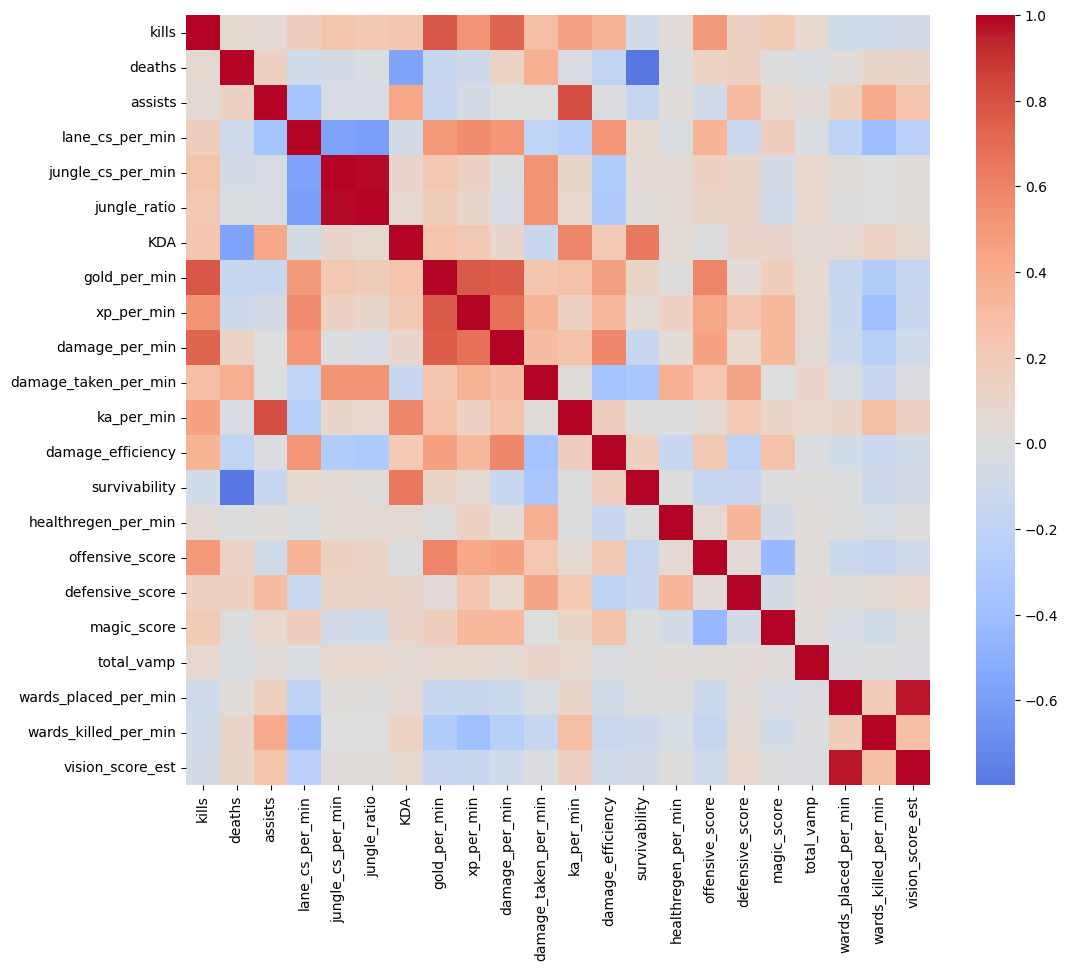

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = filtered_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)

In [188]:
import pandas as pd

# 상관계수 행렬
corr_matrix = filtered_df.corr().abs()

# 자기 자신과의 상관관계는 제외
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 상삼각행렬 마스킹
corr_matrix_masked = corr_matrix.mask(mask)

# 기준 이상 (ex: 0.8 이상)인 변수쌍 추출
high_corr_pairs = corr_matrix_masked.stack().reset_index()
high_corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# 0.8 이상인 경우만 필터링
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] >= 0.7]

# 출력
print(high_corr_pairs)

            Variable1             Variable2  Correlation
14       jungle_ratio     jungle_cs_per_min     0.984167
229  vision_score_est  wards_placed_per_min     0.960431
57         ka_per_min               assists     0.809713
79      survivability                deaths     0.797452
21       gold_per_min                 kills     0.782022
35         xp_per_min          gold_per_min     0.768022
43     damage_per_min          gold_per_min     0.760941
36     damage_per_min                 kills     0.729188


In [189]:
drop_col = ['jungle_ratio', 'vision_score_est', 'deaths', 'assists', 'kills']
filtered_df = filtered_df.drop(columns=drop_col)

In [190]:
# 상관계수 행렬
corr_matrix = filtered_df.corr().abs()

# 자기 자신과의 상관관계는 제외
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 상삼각행렬 마스킹
corr_matrix_masked = corr_matrix.mask(mask)

# 기준 이상 (ex: 0.8 이상)인 변수쌍 추출
high_corr_pairs = corr_matrix_masked.stack().reset_index()
high_corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# 0.8 이상인 경우만 필터링
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] >= 0.8]

# 출력
print(high_corr_pairs)

Empty DataFrame
Columns: [Variable1, Variable2, Correlation]
Index: []


In [194]:
merged_df = pd.concat([grouped_df['puuid'], filtered_df], axis=1)

In [195]:
merged_df.isnull().sum()

puuid                   0
lane_cs_per_min         0
jungle_cs_per_min       0
KDA                     0
gold_per_min            0
xp_per_min              0
damage_per_min          0
damage_taken_per_min    0
ka_per_min              0
damage_efficiency       0
survivability           0
healthregen_per_min     0
offensive_score         0
defensive_score         0
magic_score             0
total_vamp              0
wards_placed_per_min    0
wards_killed_per_min    0
dtype: int64

In [196]:
merged_df

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
0,--UU6P3gS9XNXShhKrJjdwtMnSJhAhf1UwYbnXkteqewk9...,2.541444,0.037034,2.726984,326.166208,284.953724,424.448871,696.504767,0.420603,0.624695,0.268027,33.636125,296.142857,126.571429,49.714286,0.0,1.275884,0.329068
1,-0PkJKNOrIe1cG-0lX_um4tEVXO7QvPRCfcgxaU9JZ9PIf...,4.605603,2.730754,1.800000,396.459185,478.172058,704.375912,946.124550,0.364065,0.858635,0.225000,32.174180,285.500000,122.000000,233.000000,0.0,0.289675,0.086546
2,-0o6aHvXTe3xfjgA2mJbTCM85Y9vsqmgVmIBj-GX5sQV0m...,0.382491,6.871390,7.750000,387.689206,507.891553,529.058669,912.637495,0.423278,0.599451,0.625000,44.342066,255.000000,158.500000,263.000000,0.0,0.199846,0.307304
3,-1S8Vgzl5o8qRc1J24lsOqEi7WemMWiln924OtaniSSXZ-...,7.273737,0.015468,4.263889,406.707915,492.078102,874.762058,578.421308,0.670765,1.505342,0.263889,28.844061,213.333333,142.666667,395.666667,0.0,0.346756,0.117124
4,-5HAguWtbg0NJsVdWoBJEpAcb_8m0qXJWCTB9KBOJbC4gD...,6.272413,0.262719,2.666667,367.051112,411.286403,703.429795,914.031815,0.525438,0.769590,0.166667,25.188172,453.000000,122.000000,145.000000,0.0,0.229879,0.098520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,zuTzJktw2MnWYD9D_fYDG-brT-s577KqtSiDkg6KQQMpfJ...,1.012666,0.000000,13.000000,290.812194,358.051157,165.686041,306.347812,0.875258,0.562242,0.611111,27.634148,201.666667,104.666667,187.666667,0.0,1.024894,0.168740
2414,zwyrrvZSzsm3wctHE28o2-6Fyh9rghSWzKJKqQSMaCnLlX...,8.325295,0.000000,2.519048,435.914493,408.449208,521.067938,622.513073,0.373584,0.860420,0.428571,28.224096,409.600000,112.600000,10.000000,0.0,0.605038,0.134162
2415,zx3b47b39_fQAz0sueKSYg2MvsXyz3n3yftVu13TLBAvl7...,1.136588,0.007083,2.564524,264.354897,301.228254,289.321160,762.110048,0.527251,0.382798,0.190238,36.240010,207.400000,182.600000,45.400000,0.0,1.212318,0.277032
2416,zxeBnmRsYg-hHMiD3q76HrWVNHntwjXehUhFAxkzTc2lR7...,6.512612,0.108164,2.227083,399.508387,535.312137,965.373112,1202.632165,0.455503,0.813215,0.139583,49.464724,357.250000,193.500000,367.750000,5.0,0.203751,0.122225


In [197]:
merged_df.describe()

,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
count,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000
mean,4.812733,1.155431,4.316925,388.662787,467.888362,660.925595,869.912430,0.552504,0.827353,0.311439,40.709749,350.625189,174.172564,103.428682,0.108976,0.717463,0.173687
std,3.057934,2.087928,3.344298,69.296375,91.220906,259.603466,281.087310,0.218844,0.431718,0.204038,35.090554,112.827551,56.486348,132.846846,1.074386,1.255942,0.115555
min,0.000000,0.000000,0.000000,187.498893,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,7.816207,152.000000,54.000000,0.000000,0.000000,0.000000,0.000000
25%,1.129310,0.000000,2.161616,344.796195,415.537544,485.982984,673.650298,0.413645,0.548087,0.166667,29.186591,244.312500,136.500000,0.000000,0.000000,0.272237,0.093292
50%,6.209254,0.119729,3.500000,397.004494,481.789759,663.507465,831.276798,0.546235,0.760593,0.250000,37.049735,344.109890,164.000000,43.000000,0.000000,0.368526,0.153542
75%,7.436094,0.524605,5.408316,434.182734,528.546445,816.840464,1044.482351,0.679939,1.042972,0.375000,45.050222,436.500000,200.000000,165.375000,0.000000,0.751529,0.233239
max,10.202383,8.238908,28.000000,671.803910,755.269877,2108.894404,3450.252697,1.442956,11.644351,1.000000,1137.199144,1027.000000,620.000000,1065.000000,26.000000,17.606714,0.787834


# 유사도 분석
- 일반 유저와 Top1000 유저 간의 유사도를 수치로 계산
- 가장 유사한 상위 10~20명을 추출

## 유사도 계산용 피처 선택
- 유저의 게임 스타일을 구성하는 성능 지표

카테고리 | 예시 지표 | 의미
------ | ------- | ----
성장 | CS/Min, Gold/Min, XP/Min | 파밍 능력
전투 | KDA, KA/Min, Damage | 교전 참여도
생존 | Survivability, Damage Efficiency | 얼마나 잘 살아남는가
능력치 | offensive_score 등 | 스탯 종합
시야 | wards_placed_per_min 등 | 맵 컨트롤 능력

## 정규화 (Standard Scaler)
- 모든 feature는 단위와 크기가 다르기 때문에, 정규화를 하지 않으면 왜곡된 유사도가 계산

### 💡 StandardScaler 작동 방식     
- 평균을 0으로, 표준편차를 1로 바꾸는 방식        
    → 값의 분포가 동일한 기준에서 비교되도록 조정

In [ ]:
# Top 1000 유저 필터링
top1000_puuids = merged_df.sort_values("KDA", ascending=False)["puuid"].unique()[:1000]
merged_df["is_top1000"] = merged_df["puuid"].isin(top1000_puuids)
merged_df

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min,is_top1000
0,--UU6P3gS9XNXShhKrJjdwtMnSJhAhf1UwYbnXkteqewk9...,2.541444,0.037034,2.726984,326.166208,284.953724,424.448871,696.504767,0.420603,0.624695,0.268027,33.636125,296.142857,126.571429,49.714286,0.0,1.275884,0.329068,False
1,-0PkJKNOrIe1cG-0lX_um4tEVXO7QvPRCfcgxaU9JZ9PIf...,4.605603,2.730754,1.800000,396.459185,478.172058,704.375912,946.124550,0.364065,0.858635,0.225000,32.174180,285.500000,122.000000,233.000000,0.0,0.289675,0.086546,False
2,-0o6aHvXTe3xfjgA2mJbTCM85Y9vsqmgVmIBj-GX5sQV0m...,0.382491,6.871390,7.750000,387.689206,507.891553,529.058669,912.637495,0.423278,0.599451,0.625000,44.342066,255.000000,158.500000,263.000000,0.0,0.199846,0.307304,True
3,-1S8Vgzl5o8qRc1J24lsOqEi7WemMWiln924OtaniSSXZ-...,7.273737,0.015468,4.263889,406.707915,492.078102,874.762058,578.421308,0.670765,1.505342,0.263889,28.844061,213.333333,142.666667,395.666667,0.0,0.346756,0.117124,True
4,-5HAguWtbg0NJsVdWoBJEpAcb_8m0qXJWCTB9KBOJbC4gD...,6.272413,0.262719,2.666667,367.051112,411.286403,703.429795,914.031815,0.525438,0.769590,0.166667,25.188172,453.000000,122.000000,145.000000,0.0,0.229879,0.098520,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,zuTzJktw2MnWYD9D_fYDG-brT-s577KqtSiDkg6KQQMpfJ...,1.012666,0.000000,13.000000,290.812194,358.051157,165.686041,306.347812,0.875258,0.562242,0.611111,27.634148,201.666667,104.666667,187.666667,0.0,1.024894,0.168740,True
2414,zwyrrvZSzsm3wctHE28o2-6Fyh9rghSWzKJKqQSMaCnLlX...,8.325295,0.000000,2.519048,435.914493,408.449208,521.067938,622.513073,0.373584,0.860420,0.428571,28.224096,409.600000,112.600000,10.000000,0.0,0.605038,0.134162,False
2415,zx3b47b39_fQAz0sueKSYg2MvsXyz3n3yftVu13TLBAvl7...,1.136588,0.007083,2.564524,264.354897,301.228254,289.321160,762.110048,0.527251,0.382798,0.190238,36.240010,207.400000,182.600000,45.400000,0.0,1.212318,0.277032,False
2416,zxeBnmRsYg-hHMiD3q76HrWVNHntwjXehUhFAxkzTc2lR7...,6.512612,0.108164,2.227083,399.508387,535.312137,965.373112,1202.632165,0.455503,0.813215,0.139583,49.464724,357.250000,193.500000,367.750000,5.0,0.203751,0.122225,False


In [ ]:
merged_df.groupby('puuid').count().reset_index()

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min,is_top1000
0,--UU6P3gS9XNXShhKrJjdwtMnSJhAhf1UwYbnXkteqewk9...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,-0PkJKNOrIe1cG-0lX_um4tEVXO7QvPRCfcgxaU9JZ9PIf...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,-0o6aHvXTe3xfjgA2mJbTCM85Y9vsqmgVmIBj-GX5sQV0m...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,-1S8Vgzl5o8qRc1J24lsOqEi7WemMWiln924OtaniSSXZ-...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,-5HAguWtbg0NJsVdWoBJEpAcb_8m0qXJWCTB9KBOJbC4gD...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,zuTzJktw2MnWYD9D_fYDG-brT-s577KqtSiDkg6KQQMpfJ...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2414,zwyrrvZSzsm3wctHE28o2-6Fyh9rghSWzKJKqQSMaCnLlX...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2415,zx3b47b39_fQAz0sueKSYg2MvsXyz3n3yftVu13TLBAvl7...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2416,zxeBnmRsYg-hHMiD3q76HrWVNHntwjXehUhFAxkzTc2lR7...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [201]:
# 스케일링
scaler = StandardScaler()

# 분석 대상에서 제외할 컬럼 지정
id_columns = ['puuid', 'is_top1000']
features = merged_df.drop(columns=id_columns)

# StandardScaler 적용
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features)

# 정규화된 데이터를 다시 DataFrame으로
scaled_features = pd.DataFrame(scaled_array, columns=features.columns, index=features.index)

# 식별자 컬럼 붙이기
scaled_df = pd.concat([merged_df[id_columns], scaled_features], axis=1)

scaled_df

,puuid,is_top1000,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
0,--UU6P3gS9XNXShhKrJjdwtMnSJhAhf1UwYbnXkteqewk9...,False,-0.742906,-0.535760,-0.475517,-0.902060,-2.005817,-0.911104,-0.617045,-0.602842,-0.469519,-0.212807,-0.201624,-0.482981,-0.842876,-0.404417,-0.101452,0.444715,1.344930
1,-0PkJKNOrIe1cG-0lX_um4tEVXO7QvPRCfcgxaU9JZ9PIf...,False,-0.067749,0.754647,-0.752758,0.112531,0.112757,0.167406,0.271189,-0.861244,0.072474,-0.423729,-0.243294,-0.577329,-0.923822,0.975545,-0.101452,-0.340682,-0.754267
2,-0o6aHvXTe3xfjgA2mJbTCM85Y9vsqmgVmIBj-GX5sQV0m...,True,-1.449069,2.738189,1.026758,-0.014052,0.438622,-0.508060,0.152031,-0.590618,-0.528005,1.537098,0.103534,-0.847709,-0.277515,1.201416,-0.101452,-0.412220,1.156546
3,-1S8Vgzl5o8qRc1J24lsOqEi7WemMWiln924OtaniSSXZ-...,True,0.804960,-0.546091,-0.015862,0.260459,0.265232,0.823875,-1.037227,0.540498,1.570767,-0.233093,-0.338215,-1.217081,-0.557877,2.200266,-0.101452,-0.295224,-0.489594
4,-5HAguWtbg0NJsVdWoBJEpAcb_8m0qXJWCTB9KBOJbC4gD...,False,0.477441,-0.427648,-0.493557,-0.311938,-0.620622,0.163761,0.156992,-0.123706,-0.133826,-0.709683,-0.442421,0.907544,-0.923822,0.312991,-0.101452,-0.388302,-0.650626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,zuTzJktw2MnWYD9D_fYDG-brT-s577KqtSiDkg6KQQMpfJ...,True,-1.242948,-0.553501,2.596919,-1.412351,-1.204328,-1.908072,-2.005360,1.475115,-0.614210,1.469014,-0.372702,-1.320505,-1.230745,0.634230,-0.101452,0.244831,-0.042823
2414,zwyrrvZSzsm3wctHE28o2-6Fyh9rghSWzKJKqQSMaCnLlX...,False,1.148909,-0.553501,-0.537706,0.682020,-0.651731,-0.538847,-0.880333,-0.817740,0.076608,0.574192,-0.355886,0.522807,-1.090269,-0.703427,-0.101452,-0.089533,-0.342115
2415,zx3b47b39_fQAz0sueKSYg2MvsXyz3n3yftVu13TLBAvl7...,False,-1.202415,-0.550108,-0.524105,-1.794230,-1.827373,-1.431727,-0.383599,-0.115420,-1.029948,-0.594134,-0.127404,-1.269679,0.149225,-0.436899,-0.101452,0.394092,0.894521
2416,zxeBnmRsYg-hHMiD3q76HrWVNHntwjXehUhFAxkzTc2lR7...,False,0.556006,-0.501686,-0.625026,0.156543,0.739279,1.172983,1.183933,-0.443334,-0.032756,-0.842447,0.249548,0.058728,0.342232,1.990081,4.553330,-0.409110,-0.445440


In [229]:
# 상위 유저 데이터만 추출
X_top = scaled_df[scaled_df["is_top1000"] == True].fillna(0)
X_top = X_top.drop(columns='is_top1000')
X_top

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
2,-0o6aHvXTe3xfjgA2mJbTCM85Y9vsqmgVmIBj-GX5sQV0m...,-1.449069,2.738189,1.026758,-0.014052,0.438622,-0.508060,0.152031,-0.590618,-0.528005,1.537098,0.103534,-0.847709,-0.277515,1.201416,-0.101452,-0.412220,1.156546
3,-1S8Vgzl5o8qRc1J24lsOqEi7WemMWiln924OtaniSSXZ-...,0.804960,-0.546091,-0.015862,0.260459,0.265232,0.823875,-1.037227,0.540498,1.570767,-0.233093,-0.338215,-1.217081,-0.557877,2.200266,-0.101452,-0.295224,-0.489594
8,-AJRi0IczMhxg2SJjU3RrzFhNGgmwUr8zgOUh9FJrpxk7s...,1.479908,-0.488361,0.802449,1.026007,1.937951,0.945747,-0.447273,0.375077,0.904863,0.924340,-0.143595,0.570677,2.511346,-0.778717,-0.101452,-0.318693,-0.718717
9,-AfKDjFub1Lkd135hPxm3JdbEXflbibk_TPvnNm0CTbpWi...,1.582155,-0.490607,1.998762,2.717786,-0.284689,-0.238537,-1.751382,0.775112,1.757297,3.375374,-0.172419,0.730246,-1.331085,-0.778717,-0.101452,-0.257702,0.201234
14,-Ei5YuB1CV4cohstuYkeTX7OrAOIU_bZaRYC7Xu90rOcG4...,-0.757627,-0.530439,0.236013,-0.615307,-0.256245,-0.398840,0.551059,0.494360,-0.618207,-0.342771,0.058229,-0.384961,-0.279286,0.957476,-0.101452,1.470881,1.610038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2407,zhouqznNR0r9OEw6T7G-40hbaN7s5JidMjkxYW97vNF5rW...,-1.251150,2.451827,4.570836,0.865285,1.048362,1.306432,1.926140,0.596732,-0.234300,1.414547,0.214157,0.406676,0.660959,2.812627,-0.101452,0.688208,1.307190
2408,znTmuVKGw2_g_dApzVG2sId1sO0scMTJeeXryiMC-uNysp...,1.308921,-0.494088,0.161293,0.883800,0.842730,0.486871,-0.199061,-0.392917,0.384418,0.525710,-0.138713,0.244039,-0.507026,0.246968,0.328220,-0.337102,-0.345543
2411,zotu_CEvJgKm2YXXMpBmKAehbVqBkiMHgF_xYOFicE_IHd...,0.774709,-0.517860,0.887733,0.279660,1.309771,0.309276,0.452259,0.457430,-0.168917,0.377148,-0.364898,-0.963475,0.063606,1.437916,-0.101452,-0.330975,0.219394
2412,zrBPWcUk5Ql4A5cWw8bB4KSN8VFpREnHWOtPe38IFT3jIz...,0.678550,-0.553501,2.596919,0.344832,0.658684,-0.002615,-0.250619,1.161396,-0.003497,3.375374,0.176669,-1.308685,-1.295671,0.139824,-0.101452,-0.176067,-0.966318


In [242]:
X_target = pd.read_csv("data/result/normal.csv")
X_target = X_target.drop(columns='Unnamed: 0')
X_target

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
0,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,-1.036673,1.466676,0.414888,0.44937,0.206065,0.286351,0.627821,0.696177,-0.264621,-0.167017,1.715338,0.145067,0.076626,0.047672,0.0,0.0,0.0


## 유사도 계산 (Cosine Similarity)
- 두 벡터(유저)의 방향이 얼마나 비슷한지를 보는 지표

  - 모든 유저를 동일한 척도로 정규화

  - 기준 유저와 Top 유저 각각의 "플레이 스타일 유사도"를 수치화

  - 이제 정량적 비교가 가능해짐 → 추천, 시각화, 군집화 등 모두 이 위에서 진행됨

## 유사도 상위 유저 추출
- 기준 유저와 각 Top 유저 간의 유사도 배열

In [243]:
# 1. 식별자 컬럼 제외하고 feature만 추출
id_cols = ['puuid']
X_top_features = X_top.drop(columns=id_cols)
X_target_features = X_target.drop(columns=id_cols)

# 2. 코사인 유사도 계산 (전체 랭커 vs 신규 유저 1명)
# → 결과 shape: (랭커 수, 1)
similarities = cosine_similarity(X_top_features, X_target_features)

# 3. 결과를 DataFrame에 정리
result_df = X_top[id_cols].copy()
result_df['similarity'] = similarities.ravel()

# 4. 유사도 기준 정렬 (높은 순)
result_df = result_df.sort_values(by='similarity', ascending=False)

# 5. 상위 10명 보기
top_similar_players = result_df.head(10)
print(top_similar_players)

                                                  puuid  similarity
213   4JnyOmP6FcSX5GFchpN67tC1-hmTzLK1-tqSUyKTm_DQ3f...    0.857624
1140  TmpUJu2JbzFa97ZvMLQ2yqr4as7yGaFj-OonNbH-RblhT_...    0.799034
971   OJAxPXIfspXW_n2rvPkJrOXXwB5mLqkMlS1nX122rud9K8...    0.782005
337   7RrgN1eyFL0wZkr7Lx-RslvQnqu7ApDpr0yCRxhn1-m32A...    0.777527
1953  oadLHBtre_qsiiNRv7DAyY9CuZKUvOdkyTYmzv0pF1uxoa...    0.764462
980   OeTHCQQ9uYxn4cqsywYo309tq22tHmK-CGpe2Z7sEiwdfR...    0.759196
746   IDhs-F-Rm1bgsFHAxPKLgam_e2CuYaGx0LZRx3le5AsyeD...    0.754755
1872  m21sZ3e7VYjOGNWh6vDIbpZytSPib1z_c5a2MXVD0GyHDf...    0.754644
417   9Ve6ePaO5Gik_drqm32crw0k2k-boga431tN0zr6JfrqMd...    0.753350
1071  RbQZ9ibUN99dpA1Nru35-jBav9im9zpFzQ450J269J2uRb...    0.750053


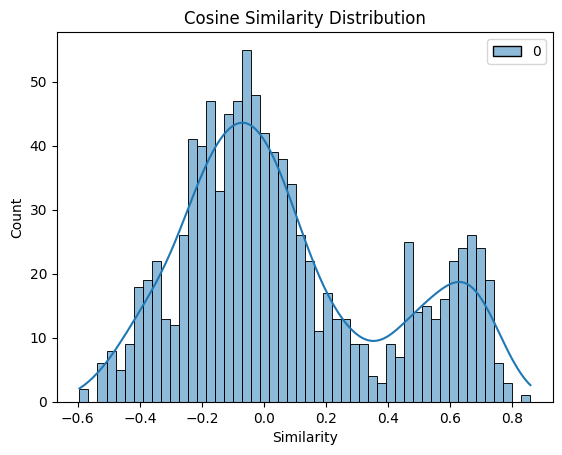

In [244]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(similarities, bins=50, kde=True)
plt.title("Cosine Similarity Distribution")
plt.xlabel("Similarity")
plt.ylabel("Count")
plt.show()

# 여기까지

In [213]:
# 일반 유저 하나 선택 (예: puuid 기반)
# target_puuid = df_user['puuid'].sample(1).values[0]
target_puuid = '1nry226Ys8jmA4IrYNRAqBOLA09dO_oisz6Din8AyUOowu80Mp3ggYKg3moP6BbiDD8d8fw9t-3IVw' 
X_target = scaled_df[scaled_df["puuid"] == target_puuid].fillna(0).iloc[0:1]
X_target


,puuid,is_top1000,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
119,1nry226Ys8jmA4IrYNRAqBOLA09dO_oisz6Din8AyUOowu...,False,0.811836,-0.474252,-0.294851,0.113802,0.854366,0.18247,0.171627,-0.788688,-0.059426,0.6421,0.66714,-0.017953,0.643252,-0.157573,-0.101452,-0.331971,-1.010124


In [222]:
import numpy as np

# 유사도 기반 거리 계산 (0~1 사이 → 가까울수록 유사함)
top_similar_players["distance"] = 1 - top_similar_players["similarity"]

# 간단한 원형 배치: 유사한 순서대로 각도를 나눠서 원 주변에 배치
angles = np.linspace(0, 2 * np.pi, len(top_similar_players), endpoint=False)
top_similar_players["x"] = np.cos(angles) * top_similar_players["distance"]
top_similar_players["y"] = np.sin(angles) * top_similar_players["distance"]

# 파생 지표 붙이기 (중복 제거 주의!)
top_features = merged_df[['puuid', "KDA", "damage_per_min", "gold_per_min"]].copy()
top_similar_players = pd.merge(
    top_similar_players,
    top_features,
    on=['puuid'],
    how="left"
)

# 기준 유저 좌표 (항상 중심)
target_user_df = pd.DataFrame({
    "puuid": [target_puuid],
    "x": [0.0],
    "y": [0.0],
    "KDA": merged_df.loc[merged_df["puuid"] == target_puuid, "KDA"].values[0],
    "damage_per_min": merged_df.loc[merged_df["puuid"] == target_puuid, "damage_per_min"].values[0],
    "gold_per_min": merged_df.loc[merged_df["puuid"] == target_puuid, "gold_per_min"].values[0],
    "label": ["Target"]
})

# 상위 유저 + 타겟 유저 병합
top_similar_players["label"] = "Top"
plot_df = pd.concat([top_similar_players, target_user_df], ignore_index=True)


In [224]:
# 기준 유저 따로 빨간 점으로 표시
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px

# Plotly용 데이터 준비
fig = px.scatter(
    plot_df,
    x="x", y="y",
    color="similarity",
    hover_data=["puuid", "KDA", "damage_per_min", "gold_per_min", "similarity"],
    text="label",
    color_continuous_scale="Viridis",
    title="Similarity-based Positioning (Target User = Center)"
)

# 기준 유저 강조 (색 없음, hover로만 표시됨)
fig.update_traces(marker=dict(size=14, line=dict(width=1, color='DarkSlateGrey')))


target_trace = px.scatter(
    target_user_df,
    x="x", y="y",
    hover_data=["KDA", "damage_per_min", "gold_per_min"],
    text=["You"],
)

target_trace.update_traces(marker=dict(size=16, color='red', symbol='star'))
fig.add_trace(target_trace.data[0])


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([['ELMfXcjWX4kJTltQlX2Z1D9Hh644IQqxbhmOnALgLJjlBfoKrqa56n96Z5Y0w6-1PAtoMWNtBtG4Ww',
                                    nan, nan, nan, 0.8983397892928541],
                                   ['e44LpTwC0GpPxqFEl_JG856m1sfl6JtAurtkIhpccpg8v5l-Uhf0wJy5PSeOLRvOwX1asmxYmuw5sg',
                                    nan, nan, nan, 0.8681076004253769],
                                   ['kAUEA8kEFRNUGeK9vCFJgBEibpWoSVNtlLordAmWudiVhzUhNuGLsrsbO5Wu6ZePhBK2wRwDI8iC4g',
                                    nan, nan, nan, 0.8587595138231059],
                                   ['fA-KkRPK-d2a93sMtYUP9EWHRdDpFaR0UXDSt7vqzvlDPXXvRI4_i83lwPZqvzMn3UkmHSzczuONBQ',
                                    nan, nan, nan, 0.8386276599100277],
                                   ['4O9vRHBah1PpackSuIHoGnK2umwSOWFgAZB82w9uORFEHZRBDyNwneOl8jbrZ3EZUe8tH5HsvAq_mA',
                                    nan, nan, nan, 0.8378609660315678],
                                   ['kPFSAI3VsTJ6gL2gQswPAkD1qf0-yL1Vx_mH0OgR5o_6r8gMtnvN-cYHY6QGnHohMl4uXMWtKxjDKQ',
                                    nan, nan, nan, 0.8167459896133433],
                                   ['khJV22ACWF4Q9frLbWnedhg6SjWREfEITkh8tfGu7NDonCg7HEh-qORcdQriS8M__JGob7QOoHWuGQ',
                                    nan, nan, nan, 0.7978292427051225],
                                   ['yip-HwTdjxXB36Pv2auxQxGcojrqrYq3gCfvitkwqB5tMxVwoFNL-IYGFZvCuxYthF0YPDj2SmHpmQ',
                                    nan, nan, nan, 0.7947696431459538],
                                   ['LVn_ok84iH0WD1I6SPS2PluVFaQVSD8ujKnyP8rOUK_O8R6d4KA3j95ajK3RRnYEvnoj2dREkm2nKA',
                                    nan, nan, nan, 0.7850964328765294],
                                   ['F_PFXXT4KK8mR0WkCpJ_9MRU0X2edJ8ClJJUN5GTK6YhiaTJULIzRkFMjR_5IoS4eH9MuaL2xPOeEg',
                                    nan, nan, nan, 0.784929474819736],
                                   ['1nry226Ys8jmA4IrYNRAqBOLA09dO_oisz6Din8AyUOowu80Mp3ggYKg3moP6BbiDD8d8fw9t-3IVw',
                                    3.331060606060606, 708.2855530274463, 396.5471999210381, nan]],
                                  dtype=object),
              'hovertemplate': ('x=%{x}<br>y=%{y}<br>label=%{te' ... '%{marker.color}<extra></extra>'),
              'legendgroup': '',
              'marker': {'color': {'bdata': ('t6r2FTO/7D+OjSeXicfrP6D4Xzv1eu' ... '2CH+k/FI0AayQe6T8AAAAAAAD4fw=='),
                                   'dtype': 'f8'},
                         'coloraxis': 'coloraxis',
                         'line': {'color': 'DarkSlateGrey', 'width': 1},
                         'size': 14,
                         'symbol': 'circle'},
              'mode': 'markers+text',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'text': array(['Top', 'Top', 'Top', 'Top', 'Top', 'Top', 'Top', 'Top', 'Top', 'Top',
                             'Target'], dtype=object),
              'type': 'scatter',
              'x': {'bdata': ('SKpKUGcGuj/Jt/WC5lC7P73vmwa7WK' ... 'ErALE/xhe/zX1Fxj8AAAAAAAAAAA=='),
                    'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': ('AAAAAAAAAADTIkC6o9izP5q0dUqmMc' ... 'FNKcq/5KLkQGAuwL8AAAAAAAAAAA=='),
                    'dtype': 'f8'},
              'yaxis': 'y'},
             {'customdata': {'bdata': 'pjFgGgOmCkA/kQbQSCKGQLhTtFTByHhA', 'dtype': 'f8', 'shape': '1, 3'},
              'hovertemplate': ('x=%{x}<br>y=%{y}<br>text=%{tex' ... '{customdata[2]}<extra></extra>'),
              'legendgroup': '',
              'marker': {'color': 'red', 'size': 16, 'symbol': 'star'},
              'mode': 'markers+text',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'text': array(['You'], dtype=object),
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAAAA=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAAA

### 2차원 좌표 생성 (PCA or t-SNE)
#### 📌 PCA란?
> PCA는 데이터의 가장 큰 **변동성(variance)** 을 유지하면서      
> 고차원 데이터를 저차원으로 압축하는 수학 기법이야.

- 데이터를 선형 조합하여 새로운 축(주성분)을 생성

- 첫 번째 축: 데이터의 가장 큰 분산 방향

- 두 번째 축: 그다음으로 큰 분산 방향 (첫 축과 직교)

단계 | 설명
--- | ---
X_vis | 유사도 상위 10명의 원본 성능 데이터
scaler.transform() | 앞에서 학습된 정규화 모델로 스케일링
pca.fit_transform() | 정규화된 데이터를 2차원으로 압축 (x, y 좌표)

In [26]:
from sklearn.decomposition import PCA

# 해당 유저들만 필터링
similar_puuids = top_similar_players["puuid"].tolist()
X_vis = merged_df[merged_df["puuid"].isin(similar_puuids)][features].fillna(0)

# PCA로 2D 압축
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.transform(X_vis))

# 위치 + 메타데이터 결합
plot_df = merged_df[merged_df["puuid"].isin(similar_puuids)].copy()
plot_df = plot_df.reset_index(drop=True)
plot_df["x"] = X_pca[:, 0]
plot_df["y"] = X_pca[:, 1]


In [27]:
# similarity 정보 복원
similarity_map = top_similar_players.set_index("puuid")["similarity"].to_dict()
plot_df["similarity"] = plot_df["puuid"].map(similarity_map)


#### 💡 PCA가 아니라 t-SNE는 안 썼는가?

기법 | 설명 | 장단점
--- | --- | ---
PCA | 선형 변환, 빠름, 해석 가능 | 빠르고 간단, 큰 구조 보기 좋음
t-SNE | 비선형, 국소적 구조 보존 | 군집 표현에 강하지만 느리고 전역 해석 어려움

### matplotlib + interactive 클릭 이벤트 시각화
vscode에서는 matplotlib이 클릭이 작동이 안됌

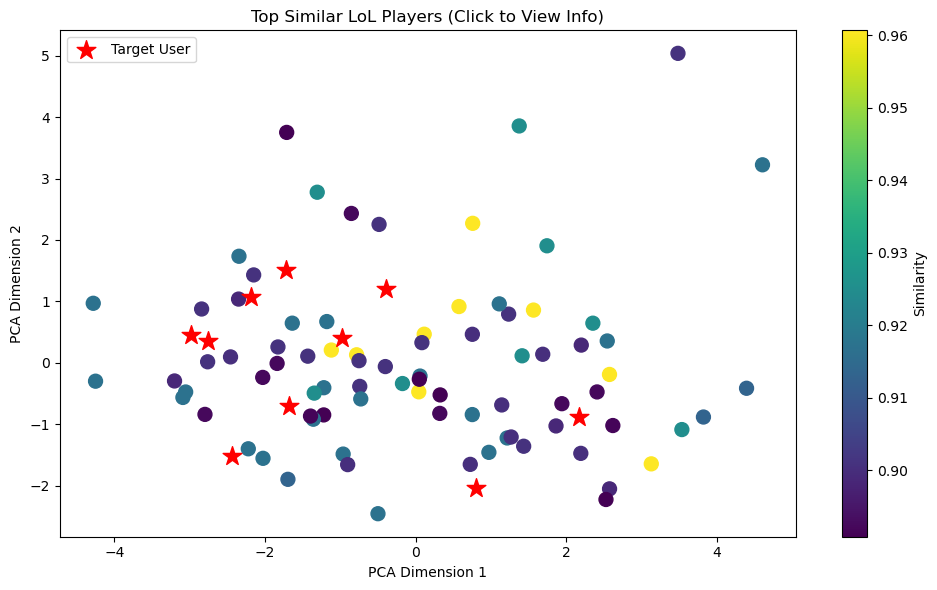

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(plot_df["x"], plot_df["y"], c=plot_df["similarity"], cmap="viridis", s=100)

# 텍스트 박스 준비
annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

# 클릭 시 작동할 함수 정의
def update_annot(ind):
    i = ind["ind"][0]
    row = plot_df.iloc[i]
    text = f"""PUUID: {row['puuid']}
                KDA: {row['KDA']:.2f}
                CS/Min: {row['cs_per_min']:.2f}
                Gold/Min: {row['gold_per_min']:.2f}
                Damage/Min: {row['damage_per_min']:.2f}
                Vision Score: {row['vision_score_est']}
                Similarity: {row['similarity']:.2f}
            """
    annot.xy = (row["x"], row["y"])
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.9)

# 마우스 클릭 이벤트 연결
def on_click(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = scatter.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("button_press_event", on_click)

# 기준 유저 좌표(★)
target_row = merged_df[merged_df["puuid"] == target_puuid].copy()
target_scaled = scaler.transform(target_row[features].fillna(0))
target_pca = pca.transform(target_scaled)
ax.scatter(target_pca[:, 0], target_pca[:, 1], c="red", marker="*", s=200, label="Target User")
ax.legend()


plt.title("Top Similar LoL Players (Click to View Info)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.colorbar(scatter, label="Similarity")
plt.tight_layout()
plt.show()

### 상대적 거리 좌표 생성 (유사도 → 거리 변환)
기준 유저를 중심으로        
유사도가 높을수록 가까운 거리,      
       낮을수록 멀리 배치

In [219]:
import numpy as np

# 유사도 기반 거리 계산 (0~1 사이 → 가까울수록 유사함)
top_similar_players["distance"] = 1 - top_similar_players["similarity"]

# 간단한 원형 배치: 유사한 순서대로 각도를 나눠서 원 주변에 배치
angles = np.linspace(0, 2 * np.pi, len(top_similar_players), endpoint=False)
top_similar_players["x"] = np.cos(angles) * top_similar_players["distance"]
top_similar_players["y"] = np.sin(angles) * top_similar_players["distance"]

# 파생 지표 붙이기 (중복 제거 주의!)
top_features = merged_df[['puuid', "KDA", "cs_per_min", "gold_per_min"]].copy()
top_similar_players = pd.merge(
    top_similar_players,
    top_features,
    on=['puuid'],
    how="left"
)

# 기준 유저 좌표 (항상 중심)
target_user_df = pd.DataFrame({
    "puuid": [target_puuid],
    "x": [0.0],
    "y": [0.0],
    "KDA": merged_df.loc[merged_df["puuid"] == target_puuid, "KDA"].values[0],
    "cs_per_min": merged_df.loc[merged_df["puuid"] == target_puuid, "cs_per_min"].values[0],
    "gold_per_min": merged_df.loc[merged_df["puuid"] == target_puuid, "gold_per_min"].values[0],
    "label": ["Target"]
})

# 상위 유저 + 타겟 유저 병합
top_similar_players["label"] = "Top"
plot_df = pd.concat([top_similar_players, target_user_df], ignore_index=True)


C:\Users\com\AppData\Local\Temp\ipykernel_124416\23735816.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_similar_players["distance"] = 1 - top_similar_players["similarity"]
C:\Users\com\AppData\Local\Temp\ipykernel_124416\23735816.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_similar_players["x"] = np.cos(angles) * top_similar_players["distance"]
C:\Users\com\AppData\Local\Temp\ipykernel_124416\23735816.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

KeyError: "['cs_per_min'] not in index"

In [30]:
# import plotly.express as px

# # Plotly용 데이터 준비
# fig = px.scatter(
#     plot_df,
#     x="x", y="y",
#     color="similarity",
#     hover_data=["puuid", "KDA", "cs_per_min", "gold_per_min", "similarity"],
#     text="label",
#     color_continuous_scale="Viridis",
#     title="Similarity-based Positioning (Target User = Center)"
# )

# # 기준 유저 강조 (색 없음, hover로만 표시됨)
# fig.update_traces(marker=dict(size=14, line=dict(width=1, color='DarkSlateGrey')))

# fig.show()


### Plotly로 시각화
- 기준 유저와 유사한 Top 유저들을 2D 공간에 배치하고    
   유사도, KDA, CS/분 등의 정보를 마우스만으로 직관적으로 파악
- 색상, 크기, 마커, 텍스트 등 시각 정보를 다차원적으로 표현



In [209]:
! pip install plotly

     ---------------------------------------- 14.8/14.8 MB 9.4 MB/s eta 0:00:00
     -------------------------------------- 331.0/331.0 KB 6.8 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\com\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [210]:
# 기준 유저 따로 빨간 점으로 표시
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px

# Plotly용 데이터 준비
fig = px.scatter(
    plot_df,
    x="x", y="y",
    color="similarity",
    # 마우스를 올리면 나오는 정보
    hover_data=["puuid", "KDA", "cs_per_min", "gold_per_min", "similarity"],
    text="label",
    color_continuous_scale="Viridis",
    title="Similarity-based Positioning (Target User = Center)"
)

# 기준 유저 강조 (색 없음, hover로만 표시됨)
fig.update_traces(marker=dict(size=14, line=dict(width=1, color='DarkSlateGrey')))


target_trace = px.scatter(
    target_user_df,
    x="x", y="y",
    hover_data=["KDA", "cs_per_min", "gold_per_min"],
    text=["You"],
)

target_trace.update_traces(marker=dict(size=16, color='red', symbol='star'))
fig.add_trace(target_trace.data[0])


NameError: name 'plot_df' is not defined

### 일반 유저 + 상위 유저 지표 비교 막대그래프 같이 그리기
- 기준 유저(일반 유저)의 최근 10게임의 KDA 변화를 시각화

- 상위 1000명 유저들의 평균 KDA 선과 비교

- 사용자에게 실력의 흐름 + 상대적 수준을 한눈에 보여주는 것

In [ ]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import pandas as pd

# # 1. 기준 유저 게임 가져오기
# user_games = merged_df[(merged_df["puuid"] == target_puuid)].copy()
# user_games = user_games.sort_values("game_id", ascending=False).head(10)

# # 2. KDA 데이터 부족 시 채우기 (0으로)
# kda_values = user_games["KDA"].tolist()
# kda_values += [0] * (10 - len(kda_values))  # 10게임 채우기

# # 2-1 CS 데이터 부족 시 채우기
# cs_values = user_games["cs_per_min"].tolist()
# cs_values += [0] * (10 - len(cs_values))


# # 3. x축 레이블
# x_labels = [f"Game {i+1}" for i in range(10)]

# # 4. Top 평균 KDA
# top_avg_kda = merged_df[merged_df["is_top1000"] == True]["KDA"].mean()

# # 4-1. Top 평균 CS
# top_avg_cs = merged_df[merged_df["is_top1000"] == True]["cs_per_min"].mean()


# # # 5. 그래프 생성
# # fig = go.Figure()

# # # 유저 KDA 막대
# # fig.add_trace(go.Bar(
# #     x=x_labels,
# #     y=kda_values,
# #     name="Target User KDA",
# #     marker_color='royalblue'
# # ))

# # # Top 유저 평균 선
# # fig.add_trace(go.Scatter(
# #     x=x_labels,
# #     y=[top_avg_kda] * 10,
# #     name="Top Players Avg KDA",
# #     mode='lines',
# #     line=dict(color='red', dash='dash')
# # ))

# # fig.update_layout(
# #     title="Recent 10 Games KDA vs Top Player Avg KDA",
# #     xaxis_title="Game",
# #     yaxis_title="KDA",
# #     barmode='group',
# #     template='plotly_white'
# # )

# # fig.show()

# # 두 개의 서브플롯 생성 (1행 2열)
# fig = make_subplots(
#     rows=1, cols=2, subplot_titles=("KDA vs Top Avg", "CS per Min vs Top Avg")
# )

# # Target 유저 데이터
# fig.add_trace(
#     go.Bar(x=x_labels, y=kda_values, name="Target User KDA", marker_color="royalblue"),
#     row=1,
#     col=1,
# )
# fig.add_trace(
#     go.Scatter(
#         x=x_labels,
#         y=[top_avg_kda] * 10,
#         name="Top Players Avg KDA",
#         line=dict(color="red", dash="dash"),
#     ),
#     row=1,
#     col=1,
# )

# fig.add_trace(
#     go.Bar(x=x_labels, y=cs_values, name="Target User CS/Min", marker_color="seagreen"),
#     row=1,
#     col=2,
# )
# fig.add_trace(
#     go.Scatter(
#         x=x_labels,
#         y=[top_avg_cs] * 10,
#         name="Top Players Avg CS/Min",
#         line=dict(color="orange", dash="dash"),
#     ),
#     row=1,
#     col=2,
# )

# # 레이아웃 설정
# fig.update_layout(
#     title_text="Recent 10 Games Comparison: KDA vs CS per Min",
#     template="plotly_white",
#     showlegend=True,
# )

# # 축 레이블 개별 설정
# fig.update_xaxes(title_text="Game", row=1, col=1)
# fig.update_yaxes(title_text="KDA", row=1, col=1)

# fig.update_xaxes(title_text="Game", row=1, col=2)
# fig.update_yaxes(title_text="CS per Min", row=1, col=2)

# fig.show()

In [34]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# 경기 10개, x축 라벨
x_labels = [f"Game {i+1}" for i in range(10)]

# 데이터 준비
user_games = merged_df[(merged_df["puuid"] == target_puuid)].copy()
user_games = user_games.sort_values("game_id", ascending=False).head(10)


def fill_10(values):
    return values.tolist() + [0] * (10 - len(values))


kda_values = fill_10(user_games["KDA"])
cs_values = fill_10(user_games["cs_per_min"])
gold_values = fill_10(user_games["gold_per_min"])
damage_values = fill_10(user_games["damage_per_min"])

# 상위 유저 평균값
top_avg_kda = merged_df[merged_df["is_top1000"] == True]["KDA"].mean()
top_avg_cs = merged_df[merged_df["is_top1000"] == True]["cs_per_min"].mean()
top_avg_gold = merged_df[merged_df["is_top1000"] == True]["gold_per_min"].mean()
top_avg_damage = merged_df[merged_df["is_top1000"] == True]["damage_per_min"].mean()

# subplot 구성
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=(
        "KDA vs Top Avg",
        "CS per Min vs Top Avg",
        "Gold per Min vs Top Avg",
        "Damage per Min vs Top Avg",
    ),
)

# (1,1) KDA
fig.add_trace(
    go.Bar(x=x_labels, y=kda_values, name="KDA", marker_color="royalblue"), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=x_labels,
        y=[top_avg_kda] * 10,
        name="Top Avg KDA",
        line=dict(color="red", dash="dash"),
    ),
    row=1,
    col=1,
)

# (1,2) CS/Min
fig.add_trace(
    go.Bar(x=x_labels, y=cs_values, name="CS/Min", marker_color="seagreen"),
    row=1,
    col=2,
)
fig.add_trace(
    go.Scatter(
        x=x_labels,
        y=[top_avg_cs] * 10,
        name="Top Avg CS",
        line=dict(color="orange", dash="dash"),
    ),
    row=1,
    col=2,
)

# (2,1) Gold/Min
fig.add_trace(
    go.Bar(x=x_labels, y=gold_values, name="Gold/Min", marker_color="goldenrod"),
    row=2,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=x_labels,
        y=[top_avg_gold] * 10,
        name="Top Avg Gold",
        line=dict(color="darkblue", dash="dash"),
    ),
    row=2,
    col=1,
)

# (2,2) Damage/Min
fig.add_trace(
    go.Bar(x=x_labels, y=damage_values, name="Damage/Min", marker_color="indianred"),
    row=2,
    col=2,
)
fig.add_trace(
    go.Scatter(
        x=x_labels,
        y=[top_avg_damage] * 10,
        name="Top Avg Damage",
        line=dict(color="black", dash="dash"),
    ),
    row=2,
    col=2,
)

# 전체 레이아웃 설정
fig.update_layout(
    title_text="Recent 10 Games Comparison (KDA / CS / Gold / Damage)",
    template="plotly_white",
    height=800,
    showlegend=False,
)

# 개별 축 설정
fig.update_xaxes(title_text="Game", row=1, col=1)
fig.update_yaxes(title_text="KDA", row=1, col=1)

fig.update_xaxes(title_text="Game", row=1, col=2)
fig.update_yaxes(title_text="CS/Min", row=1, col=2)

fig.update_xaxes(title_text="Game", row=2, col=1)
fig.update_yaxes(title_text="Gold/Min", row=2, col=1)

fig.update_xaxes(title_text="Game", row=2, col=2)
fig.update_yaxes(title_text="Damage/Min", row=2, col=2)

fig.show()

### 유사도 순 정렬된 테이블 만들기

In [33]:
import pandas as pd
from IPython.display import display

display(
    plot_df[plot_df["label"] == "Top"]
    .sort_values("similarity", ascending=False)[
        ["puuid", "KDA", "cs_per_min", "gold_per_min", "similarity"]
    ]
)


,puuid,KDA,cs_per_min,gold_per_min,similarity
0,N8s2Toz0lAW-qfSH3A0NufmmkZeVXQoqKYMDedmESurz6n...,3.333333,8.574889,517.611504,0.960658
1,JkAtetPeV8eLH-GNF14_7Z96cIMbONg0x-7yil5ZrhqURu...,5.166667,8.571203,519.099380,0.924943
2,_v3N7CJjg-9RvLsJjD-ciWb4ZtXdigRT2miD8SYenA7wnK...,3.666667,6.632733,471.255647,0.917098
3,0S7Qb-aNl4ZarGy2KldZFAAN4qum5qqCeGLJDv4vUn-d2V...,10.000000,6.606017,591.492586,0.912967
4,znTmuVKGw2_g_dApzVG2sId1sO0scMTJeeXryiMC-uNysp...,1.600000,8.204457,472.212077,0.900781
5,EVMY5lU8NxM93WsfJe1FH5irgp_daSX36OzDqSLmhoycEu...,3.400000,8.544045,474.748594,0.900137
6,BMLYrja7g84tXOAYN6an9UVxswRCySLhffkA_x8VKlFi-s...,3.750000,7.966532,496.677442,0.898521
7,mkuS-q15u1Xgel-8i20FgzR0qO16_5dV3IdJOiu6rGtQIm...,4.400000,8.686750,496.346472,0.892245
8,7UDpSRt0mNr-aRORdAY9-LXLEexD2goynSIcH63l2jRdYg...,7.250000,7.296867,525.751860,0.891860
9,Tjx_NecuU07AaxNwLyhT7sOX6kYjLTtSnwteY6g_jrpeya...,3.166667,9.751682,525.973625,0.890804
